In [145]:
from skimage.segmentation import clear_border
import pytesseract
import numpy as np
import imutils
import cv2
import matplotlib.pyplot as plt
pytesseract.pytesseract.tesseract_cmd =r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [146]:
def plt_imshow(title, image):
  # convert the image frame BGR to RGB color space and display it
    plt.figure(figsize=(10, 15))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title(title)
    plt.grid(False)
    plt.show()

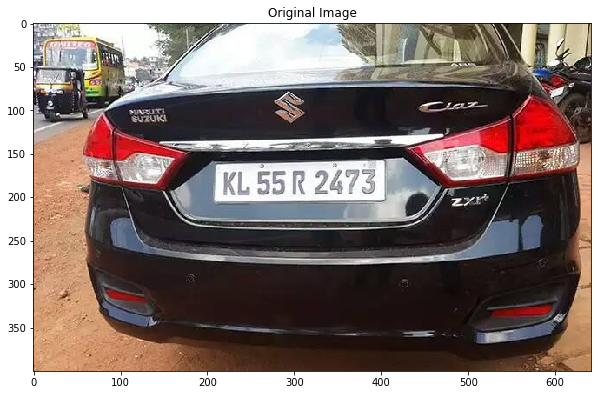

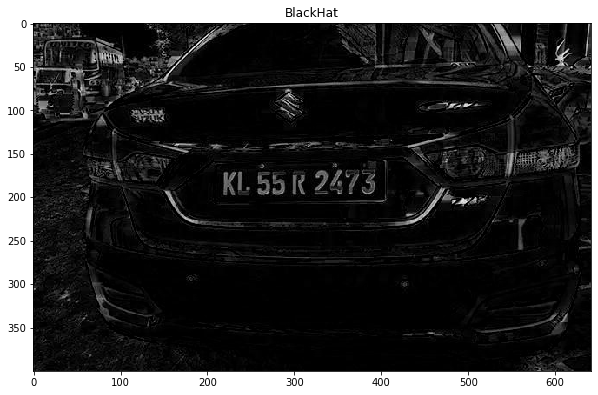

In [147]:
image = cv2.imread("../imgTEST/002.jpg")
plt_imshow("Original Image", image)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
rectKern = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 5))
blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKern)
plt_imshow("BlackHat", blackhat)

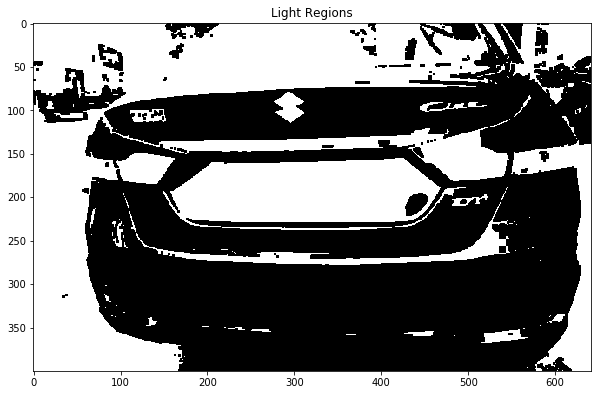

In [148]:
# next, find regions in the image that are light
squareKern = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
light = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, squareKern)
light = cv2.threshold(light, 0, 255,
cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
plt_imshow("Light Regions", light)

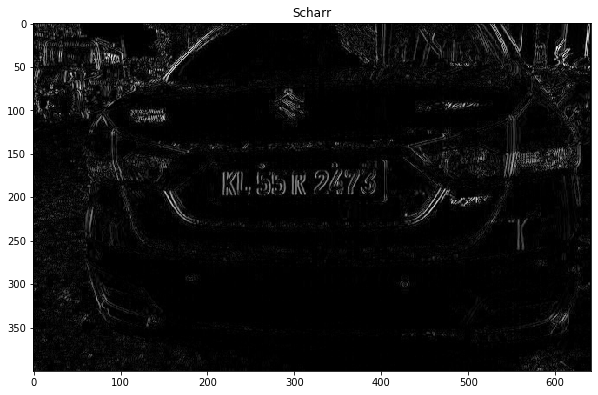

In [138]:
# compute the Scharr gradient representation of the blackhat
# image in the x-direction and then scale the result back to
# the range [0, 255]

gradX = cv2.Sobel(blackhat, ddepth=cv2.CV_32F,dx=1, dy=0, ksize=-1)
gradX = np.absolute(gradX)
(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = 255 * ((gradX - minVal) / (maxVal - minVal))
gradX = gradX.astype("uint8")
plt_imshow("Scharr", gradX)

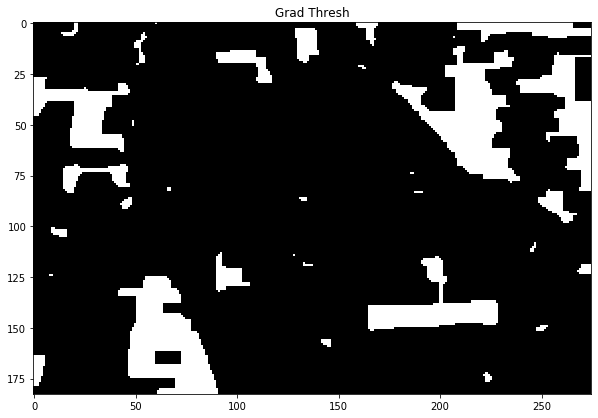

In [116]:
		# blur the gradient representation, applying a closing
		# operation, and threshold the image using Otsu's method
gradX = cv2.GaussianBlur(gradX, (5, 5), 0)
gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKern)
thresh = cv2.threshold(gradX, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
plt_imshow("Grad Thresh", thresh)

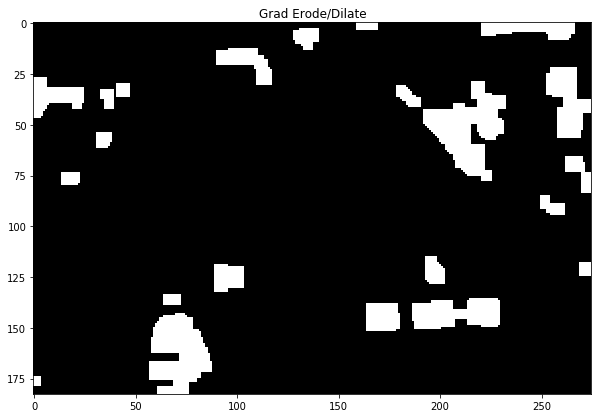

In [139]:
		# perform a series of erosions and dilations to cleanup the
		# thresholded image
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)
plt_imshow("Grad Erode/Dilate", thresh)

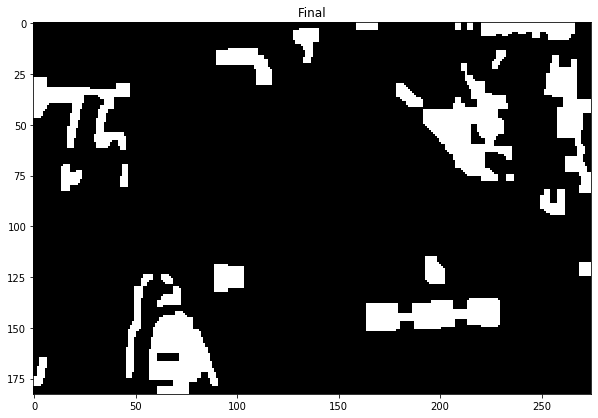

In [118]:
		# take the bitwise AND between the threshold result and the
		# light regions of the image
thresh = cv2.bitwise_and(thresh, thresh, mask=light)
thresh = cv2.dilate(thresh, None, iterations=2)
thresh = cv2.erode(thresh, None, iterations=1)
plt_imshow("Final", thresh)

In [119]:
		# find contours in the thresholded image and sort them by
		# their size in descending order, keeping only the largest
		# ones
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:5]

In [120]:
def locate_license_plate( gray, candidates,
		clearBorder=False):
		# initialize the license plate contour and ROI
		lpCnt = None
		roi = None

		# loop over the license plate candidate contours
		for c in candidates:
			# compute the bounding box of the contour and then use
			# the bounding box to derive the aspect ratio
			(x, y, w, h) = cv2.boundingRect(c)
			ar = w / float(h)

			# check to see if the aspect ratio is rectangular
			if ar >= 4 and ar <= 5:
				# store the license plate contour and extract the
				# license plate from the gray scale image and then
				# threshold it
				lpCnt = c
				licensePlate = gray[y:y + h, x:x + w]
				roi = cv2.threshold(licensePlate, 0, 255,
					cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

				# check to see if we should clear any foreground
				# pixels that are touching the border of the image
				# (which typically, not but always, indicates noise)
				if clearBorder:
					roi = clear_border(roi)

				# display any debugging information and then break
				# from the loop early since we have found the license
				# plate region
				plt_imshow("License Plate", licensePlate)
				plt_imshow("ROI", roi)
				break

		# return a 2-tuple of the license plate ROI and the contour
		# associated with it
		return (roi, lpCnt)

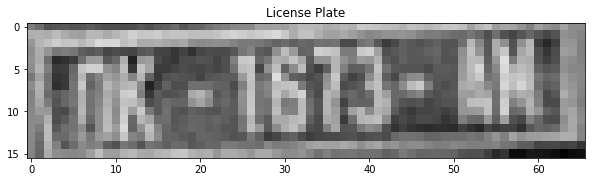

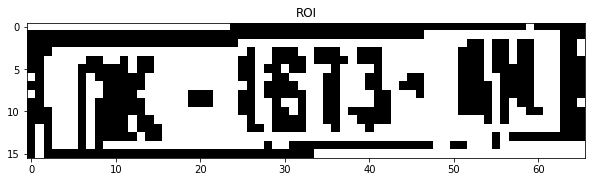

(array([[255, 255, 255, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0, 255],
        ...,
        [  0, 255,   0, ...,   0,   0,   0],
        [  0, 255,   0, ..., 255, 255, 255],
        [  0, 255,   0, ..., 255, 255, 255]], dtype=uint8),
 array([[[215, 136]],
 
        [[214, 137]],
 
        [[214, 140]],
 
        [[213, 141]],
 
        [[207, 141]],
 
        [[206, 140]],
 
        [[206, 137]],
 
        [[196, 137]],
 
        [[195, 138]],
 
        [[187, 138]],
 
        [[187, 142]],
 
        [[186, 143]],
 
        [[180, 143]],
 
        [[179, 142]],
 
        [[179, 138]],
 
        [[164, 138]],
 
        [[164, 151]],
 
        [[178, 151]],
 
        [[179, 150]],
 
        [[180, 150]],
 
        [[180, 147]],
 
        [[181, 146]],
 
        [[187, 146]],
 
        [[188, 147]],
 
        [[188, 150]],
 
        [[200, 150]],
 
        [[201, 149]],
 
        [[207, 149]],
 
        [[207, 146]],
 
      

In [121]:
locate_license_plate(gray,cnts, clearBorder=False )

In [129]:
class PyImageSearchANPR:
	def __init__(self, minAR=4, maxAR=5, debug=True):
		# store the minimum and maximum rectangular aspect ratio
		# values along with whether or not we are in debug mode
		self.minAR = minAR
		self.maxAR = maxAR
		self.debug = debug

	def debug_imshow(self, title, image, waitKey=False):
		# check to see if we are in debug mode, and if so, show the
		# image with the supplied title
		if self.debug:
			plt_imshow(title, image)

			# check to see if we should wait for a keypress
			if waitKey:
				cv2.waitKey(0)

	def locate_license_plate_candidates(self, gray, keep=5):
		# perform a blackhat morphological operation which will allow
		# us to reveal dark regions (i.e., text) on light backgrounds
		# (i.e., the license plate itself)
		rectKern = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 5))
		blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKern)
		self.debug_imshow("Blackhat", blackhat)

		# next, find regions in the image that are light
		squareKern = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
		light = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, squareKern)
		light = cv2.threshold(light, 0, 255,
			cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
		self.debug_imshow("Light Regions", light)

		# compute the Scharr gradient representation of the blackhat
		# image in the x-direction and then scale the result back to
		# the range [0, 255]
		gradX = cv2.Sobel(blackhat, ddepth=cv2.CV_32F,
			dx=1, dy=0, ksize=-1)
		gradX = np.absolute(gradX)
		(minVal, maxVal) = (np.min(gradX), np.max(gradX))
		gradX = 255 * ((gradX - minVal) / (maxVal - minVal))
		gradX = gradX.astype("uint8")
		self.debug_imshow("Scharr", gradX)

		# blur the gradient representation, applying a closing
		# operation, and threshold the image using Otsu's method
		gradX = cv2.GaussianBlur(gradX, (5, 5), 0)
		gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKern)
		thresh = cv2.threshold(gradX, 0, 255,
			cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
		self.debug_imshow("Grad Thresh", thresh)

		# perform a series of erosions and dilations to cleanup the
		# thresholded image
		thresh = cv2.erode(thresh, None, iterations=2)
		thresh = cv2.dilate(thresh, None, iterations=2)
		self.debug_imshow("Grad Erode/Dilate", thresh)

		# take the bitwise AND between the threshold result and the
		# light regions of the image
		thresh = cv2.bitwise_and(thresh, thresh, mask=light)
		thresh = cv2.dilate(thresh, None, iterations=2)
		thresh = cv2.erode(thresh, None, iterations=1)
		self.debug_imshow("Final", thresh, waitKey=True)

		# find contours in the thresholded image and sort them by
		# their size in descending order, keeping only the largest
		# ones
		cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
			cv2.CHAIN_APPROX_SIMPLE)
		cnts = imutils.grab_contours(cnts)
		cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:keep]

		# return the list of contours
		return cnts

	def locate_license_plate(self, gray, candidates,
		clearBorder=False):
		# initialize the license plate contour and ROI
		lpCnt = None
		roi = None

		# loop over the license plate candidate contours
		for c in candidates:
			# compute the bounding box of the contour and then use
			# the bounding box to derive the aspect ratio
			(x, y, w, h) = cv2.boundingRect(c)
			ar = w / float(h)

			# check to see if the aspect ratio is rectangular
			if ar >= self.minAR and ar <= self.maxAR:
				# store the license plate contour and extract the
				# license plate from the gray scale image and then
				# threshold it
				lpCnt = c
				licensePlate = gray[y:y + h, x:x + w]
				roi = cv2.threshold(licensePlate, 0, 255,
					cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

				# check to see if we should clear any foreground
				# pixels that are touching the border of the image
				# (which typically, not but always, indicates noise)
				if clearBorder:
					roi = clear_border(roi)

				# display any debugging information and then break
				# from the loop early since we have found the license
				# plate region
				self.debug_imshow("License Plate", licensePlate)
				self.debug_imshow("ROI", roi, waitKey=True)
				break

		# return a 2-tuple of the license plate ROI and the contour
		# associated with it
		return (roi, lpCnt)

	def build_tesseract_options(self, psm=7):
		# tell Tesseract to only OCR alphanumeric characters
		alphanumeric = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
		options = "-c tessedit_char_whitelist={}".format(alphanumeric)

		# set the PSM mode
		options += " --psm {}".format(psm)

		# return the built options string
		return options

	def find_and_ocr(self, image, psm=7, clearBorder=False):
		# initialize the license plate text
		lpText = None

		# convert the input image to grayscale, locate all candidate
		# license plate regions in the image, and then process the
		# candidates, leaving us with th *actual* license plate
		gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
		candidates = self.locate_license_plate_candidates(gray)
		(lp, lpCnt) = self.locate_license_plate(gray, candidates,
			clearBorder=clearBorder)

		# only OCR the license plate if the license plate ROI is not
		# empty
		if lp is not None:
			# OCR the license plate
			options = self.build_tesseract_options(psm=psm)
			lpText = pytesseract.image_to_string(lp, config=options)
			self.debug_imshow("License Plate", lp)

		# return a 2-tuple of the OCR'd license plate text along with
		# the contour associated with the license plate region
		return (lpText, lpCnt)

In [130]:
def cleanup_text(text):
	# strip out non-ASCII text so we can draw the text on the image
	# using OpenCV
	return "".join([c if ord(c) < 128 else "" for c in text]).strip()

In [131]:
args = {
	"input": "license_plates/group1",
	"clear_border": -1,
	"psm": 7,
	"debug": -1
}

In [134]:
# initialize our ANPR class
anpr = PyImageSearchANPR(debug=args["debug"] > 0)

# grab all image paths in the input directory
# imagePaths = sorted(list(paths.list_images(args["input"])))
imagePaths = ["../imgTEST/002.jpg"]

[PLATE NUMBER] ======> KL55R2473



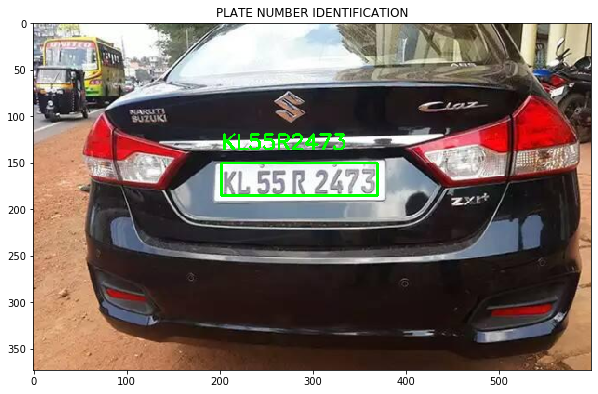

In [135]:
for imagePath in imagePaths:
    # load the input image from disk and resize it
    image = cv2.imread(imagePath)
    image = imutils.resize(image, width=600)

    # apply automatic license plate recognition
    (lpText, lpCnt) = anpr.find_and_ocr(image, psm=args["psm"],
        clearBorder=args["clear_border"] > 0)

    # only continue if the license plate was successfully OCR'd
    if lpText is not None and lpCnt is not None:
        # fit a rotated bounding box to the license plate contour and
        # draw the bounding box on the license plate
        box = cv2.boxPoints(cv2.minAreaRect(lpCnt))
        box = box.astype("int")
        cv2.drawContours(image, [box], -1, (0, 255, 0), 2)

        # compute a normal (unrotated) bounding box for the license
        # plate and then draw the OCR'd license plate text on the
        # image
        (x, y, w, h) = cv2.boundingRect(lpCnt)
        cv2.putText(image, cleanup_text(lpText), (x, y - 15),
        cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 0), 2)

        # show the output ANPR image
        print("[PLATE NUMBER] ======> {}".format(lpText))
        plt_imshow("PLATE NUMBER IDENTIFICATION", image)